In [24]:
import torch
import torch.nn as nn

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
from torch.utils.data import DataLoader, Dataset, random_split



In [25]:
class Encoder(nn.Module):
    def __init__(self, input, out):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input, out, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out,out,kernel_size=3, padding=1),
            nn.ReLU()
            )
        
        self.pool = nn.MaxPool2d((2,2))

    def forward(self,x):
        features = self.conv(x)
        downsampled = self.pool(features)

        return features, downsampled



In [26]:
class Decoder(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.up = nn.ConvTranspose2d(input, output, kernel_size=2, stride=2)

        self.conv = nn.Sequential(
            nn.Conv2d(output*2, output, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(output, output, kernel_size=3,padding=1),
            nn.ReLU()
        )

    def forward(self, x, skip):

        x = self.up(x)
        x = torch.cat([x, skip], dim=1)

        x = self.conv(x)

        return x

In [27]:
class BackgroundRemover(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_1 = Encoder(3,64)
        self.encoder_2 = Encoder(64,128)
        self.encoder_3 = Encoder(128,256)
        

        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3,padding=1),
            nn.ReLU()
        )

        self.decoder_1 = Decoder(512,256)
        self.decoder_2 = Decoder(256, 128)
        self.decoder_3 = Decoder(128,64)

        self.final_layer = nn.Conv2d(64,1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(f"Input: {x.shape}")

        skip_1, downsampled_1 = self.encoder_1(x)
        # print(f"After Enc1: {downsampled_1.shape}")

        skip_2, downsampled_2 = self.encoder_2(downsampled_1)
        # print(f"After Enc2: {downsampled_2.shape}")

        skip_3, downsampled_3 = self.encoder_3(downsampled_2)
        
        bottleneck = self.bottleneck(downsampled_3)

        decoder_1 = self.decoder_1(bottleneck, skip_3) # cahnge to skip 2
        decoder_2 = self.decoder_2(decoder_1, skip_2)
        decoder_3 = self.decoder_3(decoder_2, skip_1)

        mask = self.sigmoid(self.final_layer(decoder_3))

        return mask
        

In [28]:
class DataSetSegmentation(Dataset):
    def __init__(self, img_dir, mask_dir, transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        mask = (mask > 0.5).float()


        return image, mask

    

In [ ]:
img_dir = "Your image directory here"
mask_dir = "Your mask directory here"

In [30]:
transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor()
])

full_dataset = DataSetSegmentation(
    img_dir=img_dir,
    mask_dir=mask_dir,
    transform=transform
)

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

len(train_dataset)

2400

In [52]:
import os
from PIL import Image

def scan_dataset(image_dir, expected_size=(256, 256)):
    print(f"Scanning directory: {image_dir}")
    inconsistent_files = []
    
    # Get all image files
    files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    for i, filename in enumerate(files):
        path = os.path.join(image_dir, filename)
        try:
            with Image.open(path) as img:
                width, height = img.size
                mode = img.mode  # e.g., 'RGB', 'L' (grayscale), 'RGBA'
                
                # Check for inconsistencies
                # is_wrong_size = (width, height) != expected_size
                is_not_rgb = mode != 'RGB'
                
                if is_not_rgb:
                    inconsistent_files.append({
                        'index': i,
                        'filename': filename,
                        'size': (width, height),
                        'mode': mode
                    })
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    # Report results
    if not inconsistent_files:
        print("✅ All images are consistent!")
    else:
        print(f"❌ Found {len(inconsistent_files)} inconsistent images:")
        for item in inconsistent_files:
            print(f"Idx {item['index']} | {item['filename']} | Size: {item['size']} | Mode: {item['mode']}")
            
    return inconsistent_files

# Run it on your folder
# scan_dataset("path/to/your/images")
x = scan_dataset("/Users/hussain/Python/Data Science/P6 BG_Remover/te_images/images")

Scanning directory: /Users/hussain/Python/Data Science/P6 BG_Remover/te_images/images
❌ Found 2 inconsistent images:
Idx 1732 | ds7_pexels-photo-724887.png | Size: (2859, 1906) | Mode: RGBA
Idx 1774 | ds7_pexels-photo-842569.png | Size: (5760, 3840) | Mode: L


In [31]:
torch.manual_seed(42)
device = 'mps' if torch.mps.is_available() else 'cpu'
model = BackgroundRemover().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()


In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 7697345


In [ ]:
epoch = 0
num_epochs = 500
model_path = "Model Path Here"
state_dict = {  "epoch" : epoch,
                "model_state_dict" : model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()}

In [12]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_iter = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        predicted_mask = model(images)
        loss = criterion(predicted_mask, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if num_iter % 50 == 0:
            print(f"Iteration : {num_iter}, Train loss : {loss.item()}")
        num_iter += 1
    if epoch % 10 == 0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for images, masks in test_loader:
                # print(f"Iter : {num_iter}, image : {images.shape}")
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                predicted_mask = model(images)
                loss = criterion(predicted_mask, masks)
                
                test_loss += loss.item()
        avg_train = train_loss / len(train_loader)
        avg_test = test_loss / len(test_loader)
        torch.save(state_dict, f"{model_path}/{epoch}.pth")
        print(f"Epoch {epoch}: Train Loss {avg_train:.4f} | Test Loss {avg_test:.4f}")
        
    


Iteration : 0, Train loss : 0.6957716345787048


KeyboardInterrupt: 

Epoch 60 at 0.2990

In [69]:
test_image_path = "te_images/images/ds1_child-children-girl-happy.png"
image = Image.open(test_image_path).convert("RGB")

image = transform(image).unsqueeze(0)

image = image.to(device)

In [70]:
image.shape

torch.Size([1, 3, 512, 512])

In [36]:
torch.manual_seed(42)
device = 'mps' if torch.mps.is_available() else 'cpu'
model = BackgroundRemover().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()


In [37]:
model_path = "output/model_1/0.pth"
path = torch.load(model_path, map_location="cpu")
model.load_state_dict(path["model_state_dict"])

<All keys matched successfully>

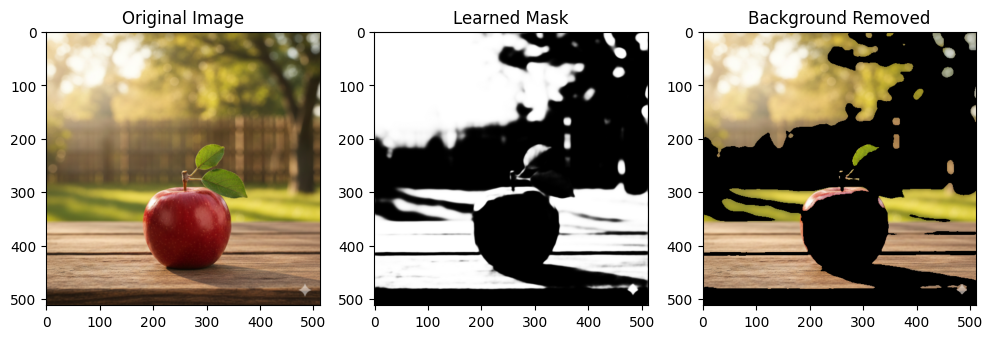

In [38]:
model.eval()
with torch.no_grad():
    # 1. Get the final mask from the model
    final_mask = model(image) 
    
    # 2. Multiply image by mask (Background Removal)
    # We use .expand(1, 3, 224, 224) to apply the 1-channel mask to all 3 RGB channels
    inverted_mask = final_mask
    binary_mask = (inverted_mask > 0.5).float()
    output_image = image * binary_mask.expand(-1, 3, -1, -1)

# Plotting the result
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image.squeeze().permute(1, 2, 0).to("cpu"))

plt.subplot(1, 3, 2)
plt.title("Learned Mask")
plt.imshow(final_mask.squeeze().to("cpu"), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Background Removed")
plt.imshow(output_image.squeeze().to("cpu").permute(1, 2, 0))
plt.show()

In [40]:
torch.manual_seed(42)
device = 'mps' if torch.mps.is_available() else 'cpu'
model_test = BackgroundRemover().to(device)
optimizer = torch.optim.Adam(model_test.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [44]:
checkpoint = torch.load(model_path, map_location='cpu')
model_test.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [74]:
test_image_path = "te_images/images/ds1_entrepreneur-startup-start-up-man-39866.png"

image = Image.open(test_image_path).convert("RGB")

image = transform(image).unsqueeze(0)

image = image.to(device)

image.shape

torch.Size([1, 3, 512, 512])

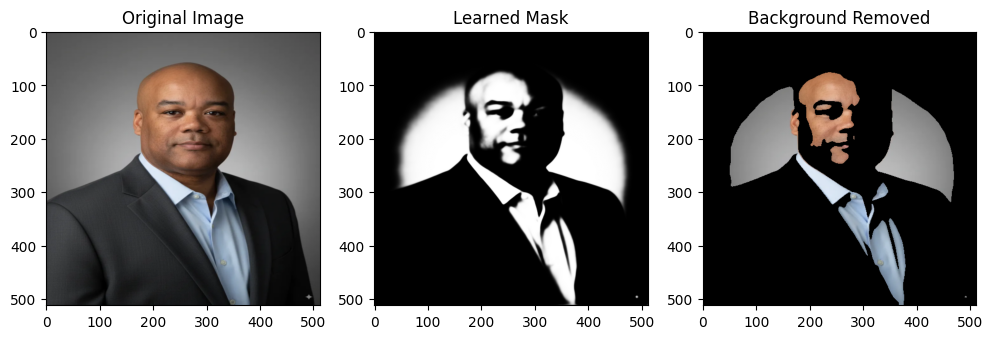

In [46]:
model_test.eval()
with torch.no_grad():
    # 1. Get the final mask from the model
    final_mask = model_test(image) 
    
    # 2. Multiply image by mask (Background Removal)
    # We use .expand(1, 3, 224, 224) to apply the 1-channel mask to all 3 RGB channels
    inverted_mask = final_mask
    binary_mask = (inverted_mask > 0.5).float()
    output_image = image * binary_mask.expand(-1, 3, -1, -1)

# Plotting the result
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image.squeeze().permute(1, 2, 0).to("cpu"))

plt.subplot(1, 3, 2)
plt.title("Learned Mask")
plt.imshow(final_mask.squeeze().to("cpu"), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Background Removed")
plt.imshow(output_image.squeeze().to("cpu").permute(1, 2, 0))
plt.show()

In [47]:
model_path = "output/model_1"

In [80]:
torch.manual_seed(42)
device = 'mps' if torch.mps.is_available() else 'cpu'
model_test_1 = BackgroundRemover().to(device)
optimizer = torch.optim.Adamax(model_test_1.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

checkpoint = torch.load(f"{model_path}/20.pth", map_location='cpu')
model_test_1.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

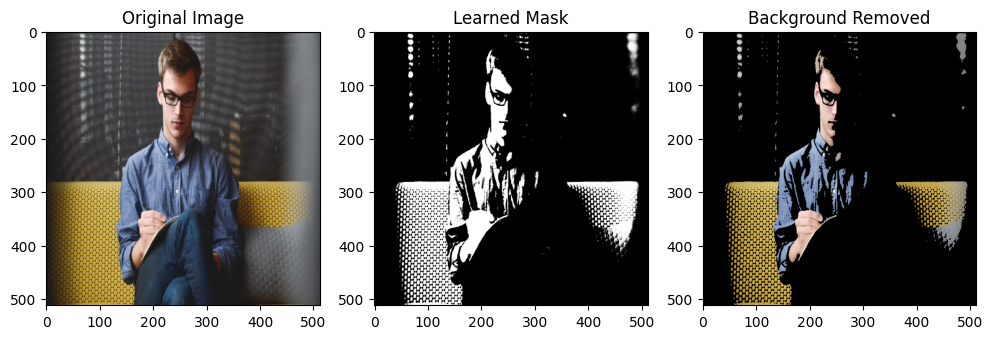

In [83]:
model_test_1.eval()
with torch.no_grad():
    # 1. Get the final mask from the model
    final_mask = model_test_1(image) 
    
    # 2. Multiply image by mask (Background Removal)
    # We use .expand(1, 3, 224, 224) to apply the 1-channel mask to all 3 RGB channels
    inverted_mask = final_mask
    binary_mask = (inverted_mask > 0.5).float()
    output_image = image * binary_mask

# Plotting the result
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image.squeeze().permute(1, 2, 0).to("cpu"))

plt.subplot(1, 3, 2)
plt.title("Learned Mask")
plt.imshow(final_mask.squeeze().to("cpu"), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Background Removed")
plt.imshow(output_image.squeeze().to("cpu").permute(1, 2, 0))
plt.show()